<a href="https://colab.research.google.com/github/ChrisCliadakis/Physics-Informed-Neural-Networks/blob/main/Burgerpinn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [0/2000], Loss: 0.48517128825187683
Epoch [100/2000], Loss: 0.012528114952147007
Epoch [200/2000], Loss: 0.0032352060079574585
Epoch [300/2000], Loss: 0.0007230631308630109
Epoch [400/2000], Loss: 0.00044607394374907017
Epoch [500/2000], Loss: 0.00024169728567358106
Epoch [600/2000], Loss: 0.00012627466639969498
Epoch [700/2000], Loss: 7.839523459551856e-05
Epoch [800/2000], Loss: 5.425972631201148e-05
Epoch [900/2000], Loss: 4.554573752102442e-05
Epoch [1000/2000], Loss: 3.6410001484910026e-05
Epoch [1100/2000], Loss: 3.5833625588566065e-05
Epoch [1200/2000], Loss: 3.5833625588566065e-05
Epoch [1300/2000], Loss: 3.5833625588566065e-05
Epoch [1400/2000], Loss: 3.5833625588566065e-05
Epoch [1500/2000], Loss: 3.5833625588566065e-05
Epoch [1600/2000], Loss: 3.5833625588566065e-05
Epoch [1700/2000], Loss: 3.5833625588566065e-05
Epoch [1800/2000], Loss: 3.5833625588566065e-05
Epoch [1900/2000], Loss: 3.5833625588566065e-05


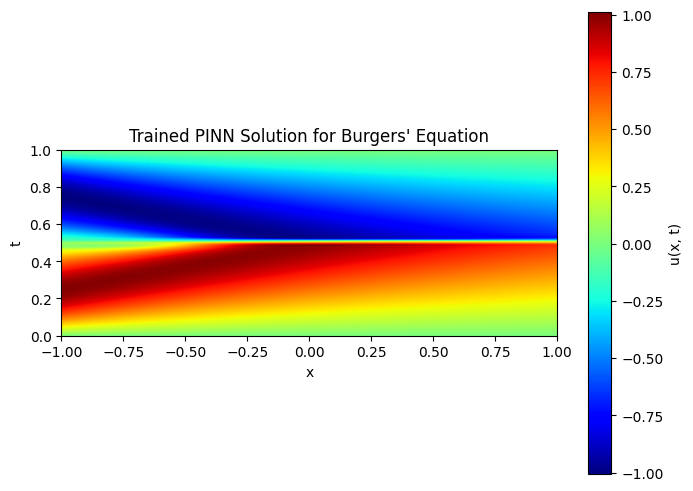

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the PINN Model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden1 = nn.Linear(2, 50)
        self.hidden2 = nn.Linear(50, 50)
        self.hidden3 = nn.Linear(50, 50)
        self.hidden4 = nn.Linear(50, 50)
        self.hidden5 = nn.Linear(50, 50)
        self.output = nn.Linear(50, 1)

    def forward(self, x):
        x = torch.tanh(self.hidden1(x))
        x = torch.tanh(self.hidden2(x))
        x = self.output(x)
        return x

# Compute Loss Function
def compute_loss(model, x, t, nu=0.01/np.pi):
    xt = torch.cat([x, t], dim=1)
    u = model(xt)

    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True, retain_graph=True)[0]
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]

    pde_residual = u_t + u * u_x - nu * u_xx

    ic_residual = model(torch.cat([x, torch.zeros_like(x)], dim=1)) + torch.sin(np.pi * x)

    bc_residual = torch.cat([
        model(torch.cat([torch.ones_like(t) * -1, t], dim=1)),
        model(torch.cat([torch.ones_like(t), t], dim=1))
    ], dim=0)

    loss = torch.mean(pde_residual**2) + torch.mean(ic_residual**2) + torch.mean(bc_residual**2)
    return loss

# Generate training data
x = torch.linspace(-1, 1, 50, requires_grad=True).view(-1, 1).to(device)
t = torch.linspace(0, 1, 50, requires_grad=True).view(-1, 1).to(device)
X, T = torch.meshgrid(x.squeeze(), t.squeeze(), indexing='ij')
x_train = X.reshape(-1, 1)
t_train = T.reshape(-1, 1)

# Initialize and Train the PINN
model = PINN().to(device)
optimizer = optim.LBFGS(model.parameters(), lr=0.1, max_iter=20, history_size=50)

def train(model, optimizer, x_train, t_train, epochs=2000):
    def closure():
        optimizer.zero_grad()
        loss = compute_loss(model, x_train, t_train)
        loss.backward()
        return loss

    for epoch in range(epochs):
        loss = optimizer.step(closure)
        if epoch % 100 == 0:
            print(f"Epoch [{epoch}/{epochs}], Loss: {loss.item()}")

train(model, optimizer, x_train, t_train, epochs=2000)

# Generate predictions from trained PINN
x_test = np.linspace(-1, 1, 500).reshape(-1, 1)
t_test = np.linspace(0, 1, 500).reshape(-1, 1)
X_test, T_test = np.meshgrid(x_test, t_test)
X_test = X_test.flatten('F').reshape(-1, 1)
T_test = T_test.flatten('F').reshape(-1, 1)
xy_test = np.hstack((X_test, T_test))
xy_test_tensor = torch.from_numpy(xy_test).float().to(device)

u_pred = model(xy_test_tensor).cpu().detach().numpy()

# Reshape trained PINN solution for visualization
u_pred_reshaped = u_pred.reshape(500, 500)

# Plot trained PINN solution in (x, t) coordinates
fig, ax = plt.subplots(figsize=(8, 6))
img = ax.imshow(np.flip(u_pred_reshaped, axis=0), cmap='jet', extent=[-1, 1, 0, 1], aspect=0.75)
plt.colorbar(img, ax=ax, label="u(x, t)")
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_title("Trained PINN Solution for Burgers' Equation")
plt.show()
